In [9]:
%matplotlib inline
import numpy as np

In [29]:
import nengo

N = 50
D = 1
seed = 7
tau = 0.1
L = 5

train_model = nengo.Network()
with train_model:
    state = nengo.Ensemble(n_neurons=N, dimensions=D, seed=seed)
    #train_signal = nengo.Node(nengo.processes.WhiteNoise(duration=L, high=10).f(), size_out=D)
    train_signal = nengo.Node(nengo.processes.WhiteSignal(period=L, high=10), size_out=D)
    nengo.Connection(train_signal, state, synapse=None)
    
    probe_signal = nengo.Probe(train_signal, synapse=None)
    spikes = nengo.Probe(state.neurons)#, synapse=tau)
    

In [30]:
sim = nengo.Simulator(train_model)
sim.run(L)

Simulation finished in 0:00:01.                                                 


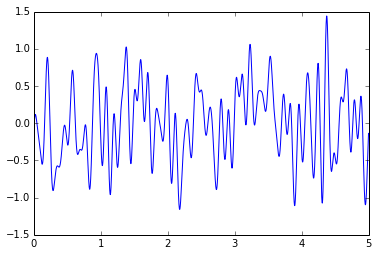

In [31]:
import pylab

pylab.plot(sim.trange(), sim.data[probe_signal])
pylab.show()

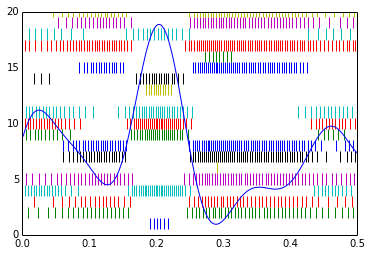

In [32]:
import nengo.utils.matplotlib
nengo.utils.matplotlib.rasterplot(sim.trange(), sim.data[spikes], use_eventplot=True)
pylab.plot(sim.trange(), sim.data[probe_signal]*10 + 10)
pylab.xlim(0,0.5)
pylab.ylim(0,20)
pylab.show()

In [37]:
solver = nengo.solvers.LstsqL2(reg=0.1)

filt_spikes = nengo.synapses.filt(sim.data[spikes], nengo.synapses.Lowpass(tau), dt=0.001)


target = sim.data[probe_signal]
target = nengo.synapses.filt(target, nengo.synapses.Lowpass(tau), dt=0.001)

decoder, info = solver(filt_spikes, target)

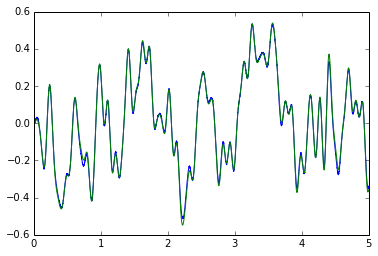

In [38]:
pylab.plot(sim.trange(), np.dot(filt_spikes, decoder))
pylab.plot(sim.trange(), target)
pylab.show()

In [43]:
model = nengo.Network()
with model:
    state = nengo.Ensemble(n_neurons=N, dimensions=D, seed=seed)
    test_signal = nengo.Node(nengo.processes.WhiteSignal(period=L, high=10), size_out=D)
    nengo.Connection(test_signal, state, synapse=None)
    
    out1 = nengo.Ensemble(n_neurons=50, dimensions=D, seed=2)
    out2 = nengo.Ensemble(n_neurons=50, dimensions=D, seed=2)
    
    nengo.Connection(state, out1, function = lambda x: x)
    nengo.Connection(state.neurons, out2, transform=decoder.T)
    
    probe1 = nengo.Probe(out1, synapse=tau)
    probe2 = nengo.Probe(out2, synapse=tau)
    

In [44]:
sim2 = nengo.Simulator(model)
sim2.run(5)

Simulation finished in 0:00:03.                                                 


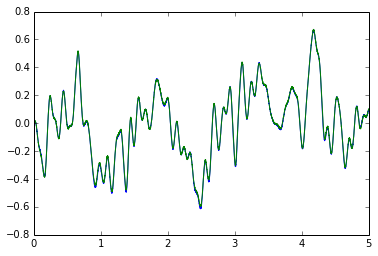

In [45]:
pylab.plot(sim2.trange(), sim2.data[probe1])
pylab.plot(sim2.trange(), sim2.data[probe2])
pylab.show()

## Reservoir

In [49]:
import nengo

N = 500
D = 1
seed = 7
tau = 0.1
L = 10

train_model = nengo.Network()
with train_model:
    state = nengo.Ensemble(n_neurons=N, dimensions=D, seed=seed)#, neuron_type=nengo.Sigmoid())
    train_signal = nengo.Node(nengo.processes.WhiteSignal(period=L, high=3), size_out=D)
    nengo.Connection(train_signal, state, synapse=None)

    probe_signal = nengo.Probe(train_signal, synapse=None)
    spikes = nengo.Probe(state.neurons, synapse=tau)
    
    weights = np.random.uniform(-0.5, 0.5, size=(N, N))
    scale = 1.0 / np.max(np.abs(np.linalg.eigvals(weights)**2))
    weights *= scale
    nengo.Connection(state.neurons, state.neurons, transform=weights / 50, synapse=tau)
    


Simulation finished in 0:00:05.                                                 


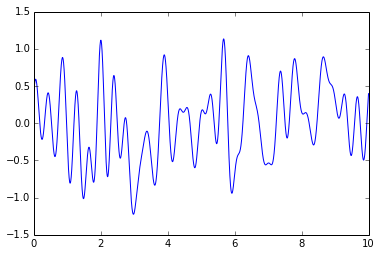

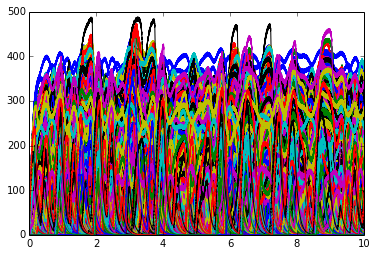

In [50]:
sim = nengo.Simulator(train_model)
sim.run(L)
pylab.plot(sim.trange(), sim.data[probe_signal])
pylab.show()
pylab.plot(sim.trange(), sim.data[spikes])
pylab.show()

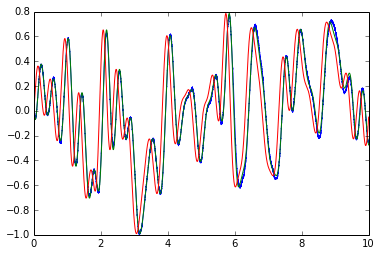

In [53]:
solver = nengo.solvers.LstsqL2(reg=0.02)

target = np.roll(sim.data[probe_signal], 100)
target = nengo.synapses.filt(target, nengo.synapses.Lowpass(tau), dt=0.001)

N = len(target) / 2
decoder, info = solver(sim.data[spikes][:N], target[:N])

pylab.plot(sim.trange(), np.dot(sim.data[spikes], decoder))
pylab.plot(sim.trange(), target)
pylab.plot(sim.trange(), nengo.synapses.filt(sim.data[probe_signal], nengo.synapses.Lowpass(tau), dt=0.001))
pylab.show()

In [56]:
def compute_error(roll):
    solver = nengo.solvers.LstsqL2(reg=0.02)
    
    target = np.roll(sim.data[probe_signal], roll)
    target = nengo.synapses.filt(target, nengo.synapses.Lowpass(tau), dt=0.001)
    
    N = len(target) / 2
    decoder, info = solver(sim.data[spikes][:N], target[:N])
    
    predict = np.dot(sim.data[spikes][N:], decoder)
    
    rms = nengo.utils.numpy.rms(target[N:] - predict, axis=0)
    
    return rms#info['rmses'][0]

In [57]:
rolls = range(-200, 401, 20)
errors = [compute_error(r) for r in rolls]

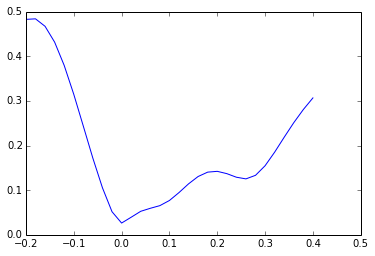

In [44]:
plot(numpy.array(rolls)*0.001, errors)
show()